This notebook presents a simulation of 5000 ms of 400 descending commands and 800 motoneurons from soleus. The force is prduced by a Hill-type muscle model. 

In [1]:
import sys
sys.path.insert(0, '..')
import time
import matplotlib.pyplot as plt
%matplotlib notebook 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"


import numpy as np

from Configuration import Configuration
from MotorUnitPool import MotorUnitPool
from NeuralTract import NeuralTract
from AfferentPool import AfferentPool
from SynapsesFactory import SynapsesFactory
from jointAnkleForceTask import jointAnkleForceTask
from numba import jit, prange
import scipy as sc
from scipy.signal import *


In [2]:
conf = Configuration('confForceVariability.rmto')
conf.simDuration_ms = 100 # Here I change simulation duration without changing the Configuration file.
t = np.arange(0.0, conf.simDuration_ms, conf.timeStep_ms)

In [3]:
#FR = np.array([95.0, 110.0 ,125.0, 140.0, 155.0, 170.0, 185.0, 200.0, 250])
FR = np.array([95.0, 110.0])
GammaOrder = np.array([7, 5, 4, 4, 4, 3, 2, 2, 1])
condVelS = np.linspace(44/2.0, 44*2.0, 5)
condVelFR = np.linspace(51/2.0, 51*2.0, 5)
condVelFF1 = np.linspace(52/2.0, 52*2.0, 5)
condVelFF2 = np.linspace(53/2.0,53*2, 5)


forceSOL = np.empty((len(t),len(FR), len(condVelS)))
forceMG = np.empty((len(t),len(FR), len(condVelS)))
forceLG = np.empty((len(t),len(FR), len(condVelS)))
torque = np.empty((len(t), len(FR), len(condVelS)))
spikesSOLTerminal = dict()
spikesMGTerminal = dict()
spikesLGTerminal = dict()
spikesSOLSoma = dict()
spikesMGSoma = dict()
spikesLGSoma = dict()

for m in xrange(len(condVelS)):
    
    conf.changeConfigurationParameter('axonDelayCondVel:MG-S',condVelS[m],condVelFR[m])
    conf.changeConfigurationParameter('axonDelayCondVel:SOL-S',condVelS[m],condVelFR[m])
    conf.changeConfigurationParameter('axonDelayCondVel:LG-S',condVelS[m],condVelFR[m])
    conf.changeConfigurationParameter('axonDelayCondVel:MG-FR',condVelFR[m],condVelFF1[m])
    conf.changeConfigurationParameter('axonDelayCondVel:SOL-FR',condVelFR[m],condVelFF1[m])
    conf.changeConfigurationParameter('axonDelayCondVel:LG-FR',condVelFR[m],condVelFF1[m])
    conf.changeConfigurationParameter('axonDelayCondVel:MG-FF',condVelFF1[m],condVelFF2[m])
    conf.changeConfigurationParameter('axonDelayCondVel:SOL-FF',condVelFF1[m],condVelFF2[m])
    conf.changeConfigurationParameter('axonDelayCondVel:LG-FF',condVelFF1[m],condVelFF2[m])
    
    
    
    pools = dict()
    pools[0] = MotorUnitPool(conf, 'SOL')
    pools[1] = MotorUnitPool(conf, 'MG')
    pools[2] = MotorUnitPool(conf, 'LG')
    pools[3] = NeuralTract(conf, 'CMExt')
    ankle = jointAnkleForceTask(conf, pools)
    Syn = SynapsesFactory(conf, pools)
    del Syn



    for l in xrange(0, len(FR)):
        print('Firing Rate ' + str(FR[l]))
        tic = time.time()
        for i in xrange(0,len(t)-1): 
            pools[3].atualizePool(t[i], FR[l], GammaOrder[l])
            ankle.atualizeAnkle(t[i], 0.0)
            for j in xrange(3):
                pools[j].atualizeMotorUnitPool(t[i])
            ankle.computeTorque(t[i])

        toc = time.time() 
        
        pools[0].listSpikes()
        pools[1].listSpikes()
        pools[2].listSpikes()

        forceSOL[:,l,m] = np.squeeze(pools[0].Muscle.force)
        forceMG[:,l,m] = np.squeeze(pools[1].Muscle.force)
        forceLG[:,l,m] = np.squeeze(pools[2].Muscle.force)
        torque[:,l,m] = np.squeeze(ankle.ankleTorque_Nm)
        spikesSOLTerminal['FR' + str(l) + 'delay' + str(m)] = pools[0].poolTerminalSpikes
        spikesMGTerminal['FR' + str(l) + 'delay' + str(m)] = pools[1].poolTerminalSpikes
        spikesLGTerminal['FR' + str(l) + 'delay' + str(m)] = pools[2].poolTerminalSpikes
        spikesSOLSoma['FR' + str(l) + 'delay' + str(m)] = pools[0].poolSomaSpikes
        spikesMGSoma['FR' + str(l) + 'delay' + str(m)] = pools[1].poolTerminalSpikes
        spikesLGSoma['FR' + str(l) + 'delay' + str(m)] = pools[2].poolTerminalSpikes
        
        print str(toc - tic) + ' seconds'
        for k in xrange(0, len(pools)):
            pools[k].reset()

Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Muscle spindle from muscle MG built.
Motor Unit Pool MG built
Muscle spindle from muscle LG built.
Motor Unit Pool LG built
Descending Command CMExt built
Ankle joint for Force Task built
All the 211334 synapses were built
All the 0 synaptic noises were built
Firing Rate 95.0
385.285275936 seconds
Firing Rate 110.0
456.503091097 seconds
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Muscle spindle from muscle MG built.
Motor Unit Pool MG built
Muscle spindle from muscle LG built.
Motor Unit Pool LG built
Descending Command CMExt built
Ankle joint for Force Task built
All the 210859 synapses were built
All the 0 synaptic noises were built
Firing Rate 95.0
395.266412973 seconds
Firing Rate 110.0
400.532778025 seconds
Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Muscle spindle from muscle MG built.
Motor Unit Pool MG built
Muscle spindle from muscle LG built.
Motor Unit Pool LG built
Descen

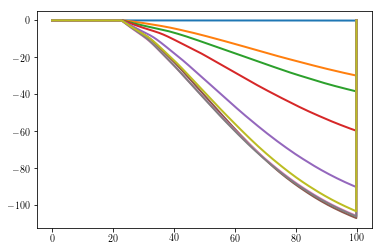

In [8]:
forceLG.shape

plt.figure()
plt.plot(t, torque[:,:,1])

In [ ]:
plt.figure()
plt.plot(t, forceSOL)

In [ ]:
plt.figure()
plt.plot(t, forceMG)

In [ ]:
plt.figure()
plt.plot(t, forceLG)

In [ ]:
np.save('forceSol',forceSOL,)
np.save('forceMG', forceMG)
np.save('forceLG', forceLG)
np.save('torque', torque)

In [ ]:
X=np.load('forceSol.npy')

In [ ]:
X

In [6]:
spikesSOLTerminal=dict()
spikesSOLTerminal['FR' + str(l) + 'delay' + str(m)] = pools[0].poolTerminalSpikes


In [7]:
spikesLGSoma

{'FR0delay0': array([[ 51.7,   0. ],
        [ 86.4,   0. ]]), 'FR0delay1': array([[ 47.3 ,   1.  ],
        [ 90.65,   1.  ],
        [ 65.1 ,   2.  ],
        [ 35.25,   3.  ],
        [ 67.95,   3.  ],
        [ 49.3 ,   4.  ],
        [ 89.9 ,   4.  ]]), 'FR0delay2': array([[ 41.2 ,   0.  ],
        [ 77.4 ,   0.  ],
        [ 40.25,   1.  ],
        [ 82.85,   1.  ]]), 'FR0delay3': array([[ 31.55,   0.  ],
        [ 66.5 ,   0.  ],
        [ 99.85,   0.  ]]), 'FR0delay4': array([[ 32.35,   0.  ],
        [ 70.1 ,   0.  ],
        [ 32.4 ,   1.  ],
        [ 69.05,   1.  ],
        [ 99.45,   1.  ],
        [ 99.6 ,   2.  ]]), 'FR1delay0': array([[ 41.35,   0.  ],
        [ 52.45,   0.  ],
        [ 63.9 ,   0.  ],
        [ 75.25,   0.  ],
        [ 87.  ,   0.  ],
        [ 98.05,   0.  ],
        [ 41.15,   1.  ],
        [ 56.4 ,   1.  ],
        [ 71.8 ,   1.  ],
        [ 87.75,   1.  ],
        [ 40.95,   2.  ],
        [ 51.05,   2.  ],
        [ 60.9 ,   2.  ],
        [ 7

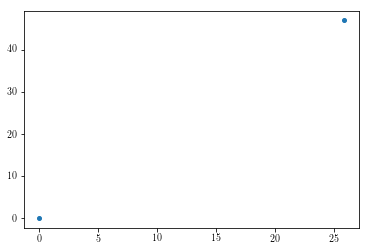

In [5]:
plt.plot(spikesLGSoma['FR1delay1'][0],spikesLGSoma['FR1delay1'][1],'.')

In [6]:
np.save('spikes', spikesLGSoma)

In [8]:
import pickle


In [9]:
output = open('myfile.pkl', 'wb')
pickle.dump(spikesLGSoma, output)
output.close()

In [13]:
f = open('spikeTimes.pkl', 'wb')
pickle.dump([spikesSOLSoma, spikesMGSoma,  spikesLGSoma, spikesSOLTerminal, spikesMGTerminal,  spikesLGTerminal], f)
f.close()


f = open('spikeTimesLGSoma.pkl', 'wb')
pickle.dump(spikesLGSoma, f)
f.close()
f = open('spikeTimesMGSoma.pkl', 'wb')
pickle.dump(spikesMGSoma, f)
f.close()
f = open('spikeTimesSOLSoma.pkl', 'wb')
pickle.dump(spikesSOLSoma, f)
f.close()
f = open('spikeTimesLGTerminal.pkl', 'wb')
pickle.dump(spikesLGSoma, f)
f.close()
f = open('spikeTimesMGTerminal.pkl', 'wb')
pickle.dump(spikesMGSoma, f)
f.close()
f = open('spikeTimesSOLSoma.pkl', 'wb')
pickle.dump(spikesSOLSoma, f)
f.close()
